Analysis the results under new code

In [40]:
import sys
sys.path.append("../../mypkg")

In [41]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.metrics import roc_auc_score, f1_score
from numbers import Number

from joblib import Parallel, delayed

from easydict import EasyDict as edict
from tqdm import trange, tqdm
from scipy.io import loadmat
from pprint import pprint
import itertools
from scipy.stats import chi2
import pandas as pd
from IPython.display import display


In [42]:
# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
from constants import DATA_ROOT, RES_ROOT, FIG_ROOT, MIDRES_ROOT

from utils.matrix import col_vec_fn, col_vec2mat_fn, conju_grad, svd_inverse, cholesky_inv
from utils.misc import save_pkl, load_pkl, get_local_min_idxs, bcross_entropy_loss
from scenarios.real_simu_logi import settings
from scenarios.real_simu_logi_meg import settings as settingms



In [44]:
import logging

logger = logging.getLogger("tmp")
logger.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')

ch = logging.StreamHandler() # for console. 
ch.setLevel(logging.DEBUG)
ch.setFormatter(formatter)

logger.addHandler(ch)

In [45]:
from optimization.opt import logger as logger1
logger1.handlers[0].setLevel(logging.WARNING)

In [46]:
plt.style.use(FIG_ROOT/"base.mplstyle")
torch.set_default_dtype(torch.float64)

In [47]:
def _get_min_idx(x):
    """Get the index of the minimal values among the local minimals.
       If there are multiple ones, return the largest index
       args:
           x: a vec
        
    """
    x = np.array(x)
    lmin_idxs = get_local_min_idxs(x);
    if len(lmin_idxs) == 0:
        lmin_idxs = np.arange(len(x))
    lmin_idxs_inv =  lmin_idxs[::-1]
    lmins_inv = x[lmin_idxs_inv];
    return  lmin_idxs_inv[np.argmin(lmins_inv)]

# Analysis

In [71]:
setting = settings["n2a"]
#setting = settingms["nm2a"]

can_Ns = setting.can_Ns
can_lams = setting.can_lams
print(can_lams)

c1s = [0.0, 0.1, 0.2, 0.4]
Cmat = np.eye(1) # change it depending on test1, test2, test3
Cmat = np.array([
    [1, -1], 
]).reshape(1, -1)
file_prefix = f"simu_logi_setting{setting.setting}"
loss_name = "entropy_loss"
#loss_name = "mse_loss"

sel_lam = 0.4
sel_N = 10
num_rep = 200;

[0.001, 0.01, 0.05, 0.08, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 16.0]


# Fixed N and fixed lam

In [74]:
def _run_fn1(seed, all_cv_errs):
    errs_mat = []
    for cur_N in can_Ns:
        errs = []
        for cur_lam in can_lams:
            cur_res = all_cv_errs[(seed, cur_N, cur_lam)]
            errs.append(cur_res[loss_name])
            #errs.append(1-f1_score(cur_res.tY, cur_res.cv_probs>0.5))
            #errs.append(1-roc_auc_score(cur_res.tY, cur_res.cv_probs))
        errs_mat.append(errs)
    errs_mat = np.array(errs_mat)
    return errs_mat
opt_lamNs_fix = {}
for c1 in c1s:
    cur_save_dir = RES_ROOT/f"{file_prefix}_{c1*1000:.0f}"
    all_cv_errs = load_pkl(cur_save_dir/f"all-valsel-metrics.pkl")
    num_seed = len(np.unique(list(map(lambda x: x[0], all_cv_errs.keys()))))
    # do not make n_jobs>1, it is very slow
    with Parallel(n_jobs=1) as parallel:
        err_ten = parallel(delayed(_run_fn1)(cur_seed, all_cv_errs)  
                                 for cur_seed in tqdm(range(num_seed), total=num_seed, desc=f"c1: {c1}"))
    err_ten = np.array(err_ten);
    
    err_m = np.median(np.array(err_ten), axis=0)
    print(err_m[can_Ns.index(sel_N)])
    lam_min_idx = _get_min_idx(err_m[can_Ns.index(sel_N)])
    sel_lam = can_lams[lam_min_idx]
    
    opt_lamNs_fix[c1] = (sel_N,  sel_lam)

Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_real/../../mypkg/../results/simu_logi_settingn2a_0/all-valsel-metrics.pkl


c1: 0.0: 100%|██████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 13012.05it/s]


[1.08293697 1.08293697 1.16246553 1.06825278 0.36177701 0.26275195
 0.2855365  0.32166033 0.35256507 0.36259542 0.36259542 0.36259542
 0.36259542 0.36259542 0.36259542 0.36259542]
Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_real/../../mypkg/../results/simu_logi_settingn2a_100/all-valsel-metrics.pkl


c1: 0.1: 100%|██████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 13792.06it/s]


[1.01247785 1.01247785 1.10314296 0.99854761 0.3461268  0.25768023
 0.28053911 0.31752635 0.34001213 0.34357975 0.34357975 0.34357975
 0.34357975 0.34357975 0.34357975 0.34357975]
Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_real/../../mypkg/../results/simu_logi_settingn2a_200/all-valsel-metrics.pkl


c1: 0.2: 100%|██████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 13287.41it/s]


[1.00667487 1.00667487 1.05190171 0.94011869 0.34368937 0.2553008
 0.27656951 0.31282174 0.33827341 0.3406917  0.3406917  0.3406917
 0.3406917  0.3406917  0.3406917  0.3406917 ]
Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_real/../../mypkg/../results/simu_logi_settingn2a_400/all-valsel-metrics.pkl


c1: 0.4: 100%|██████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 13331.33it/s]

[0.94538838 0.94538838 0.97227761 0.82040212 0.34580989 0.25314166
 0.26812821 0.303262   0.31297822 0.31316087 0.31316087 0.31316087
 0.31316087 0.31316087 0.31316087 0.31316087]


In [75]:

opt_lamNs_fix

{0.0: (10, 0.2), 0.1: (10, 0.2), 0.2: (10, 0.2), 0.4: (10, 0.2)}

In [284]:
# for adaptive lam N
cans = [1e-5, 3e-6, 1e-6, 3e-7, 1e-7, 3e-8, 1e-8, 3e-9, 1e-9, 3e-10, 0]
all_coms = [(can, can) for can in cans]
#all_coms = list(itertools.product(cans, cans))
for c1 in c1s:
    sel_N, sel_lam = opt_lamNs_fix[c1]
    cur_save_dir = RES_ROOT/f"{file_prefix}_{c1*1000:.0f}"
    ress = []
    def _run_fn_test(cur_seed):
        from optimization.opt import logger as logger1
        logger1.handlers[0].setLevel(logging.WARNING)
        torch.set_default_dtype(torch.float64)
        f1_name = f"seed_{cur_seed:.0f}-lam_{sel_lam*1000:.0f}-N_{sel_N:.0f}_fit.pkl"
        res1 = load_pkl(cur_save_dir/f1_name, verbose=False);
        res1.basis_mat = torch.tensor(res1.obt_bsp(np.linspace(0, 1, setting.data_gen_params.npts), 
                                      res1.bsp_params.N, res1.bsp_params.basis_ord)).to(torch.get_default_dtype());
        res = []
        for rtols in all_coms:
            re = res1.hypo_test(Cmat=Cmat, ts=None, is_simpler=False, hypo_params={"svdinv_eps_Q": rtols[0], "svdinv_eps_Psi": rtols[1]}) 
            res.append(re)
    
        return res 
    with Parallel(n_jobs=10) as parallel:
        ress = parallel(delayed(_run_fn_test)(cur_seed) for cur_seed in tqdm(range(num_rep), desc=f"c1: {c1*1000:.0f}", total=num_rep))
    ress = np.array(ress);
    save_pkl(cur_save_dir/f"opt_lamNsfixNlam_ress.pkl", ress, is_force=1)


c1: 0: 100%|██████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 212.75it/s]


Save to /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_real/../../mypkg/../results/simu_logi_settingn2a_0/opt_lamNsfixNlam_ress.pkl



c1: 100: 100%|████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 212.04it/s]


Save to /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_real/../../mypkg/../results/simu_logi_settingn2a_100/opt_lamNsfixNlam_ress.pkl



c1: 200: 100%|████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 192.09it/s]


Save to /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_real/../../mypkg/../results/simu_logi_settingn2a_200/opt_lamNsfixNlam_ress.pkl



c1: 400: 100%|████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 150.94it/s]


Save to /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_real/../../mypkg/../results/simu_logi_settingn2a_400/opt_lamNsfixNlam_ress.pkl


## Find Q and Psi rtol

In [285]:
def outlier_det(T_vs, ratio_tol=0.05):
    """
    Detects outliers in a given dataset using the interquartile range (IQR) method.

    Parameters:
    - T_vs (array-like): The input dataset.
    - ratio_tol (float, optional): The tolerance ratio for outlier removal. Default is 0.05.

    Returns:
    - kpidx (ndarray): A boolean array indicating whether each data point is an outlier or not.
    """
    Q1, Q3 = np.quantile(T_vs, [0.25, 0.75])
    IQR = Q3 - Q1
    upbd = Q3 + 1.5*IQR
    lowbd = Q1 - 1.5*IQR
    kpidx = np.bitwise_and(T_vs>=lowbd, T_vs<=upbd)
    
    if np.mean(kpidx)+ ratio_tol < 1:
        out_part = np.stack([T_vs - upbd, lowbd - T_vs]).T.max(axis=1);
        kpidx = np.ones(len(T_vs), dtype=bool)
        kpidx[np.argsort(-out_part)[:int(len(T_vs)*ratio_tol)]] = False
    return kpidx

def outlier_det1(T_vs, ratio_tol=0.05):
    maes = np.abs(T_vs - np.median(T_vs));
    idxs = np.argsort(-maes)
    kpidx = np.ones(len(T_vs), dtype=bool)
    kpidx[idxs[:int(ratio_tol*len(T_vs))]] = False
    return kpidx

In [286]:
ress_dict = {}
for c1 in c1s:
    cur_save_dir = RES_ROOT/f"{file_prefix}_{c1*1000:.0f}"
    ress = load_pkl(cur_save_dir/f"opt_lamNsfixNlam_ress.pkl");
    ress_dict[c1] = ress

Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_real/../../mypkg/../results/simu_logi_settingn2a_0/opt_lamNsfixNlam_ress.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_real/../../mypkg/../results/simu_logi_settingn2a_100/opt_lamNsfixNlam_ress.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_real/../../mypkg/../results/simu_logi_settingn2a_200/opt_lamNsfixNlam_ress.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_real/../../mypkg/../results/simu_logi_settingn2a_400/opt_lamNsfixNlam_ress.pkl


In [287]:
import pandas as pd
cans = [1e-5, 3e-6, 1e-6, 3e-7, 1e-7, 3e-8, 1e-8, 3e-9, 1e-9, 3e-10, 0]

all_coms = np.array(list(itertools.product(cans, cans)));
all_coms = [(can, can) for can in cans]
kpidxs = []

df = []
for c1 in c1s:
    ress = ress_dict[c1]
    pvals = np.array([[re["pval"] for re in res] for res in ress]);
    T_vss = np.array([[re["T_v"] for re in res] for res in ress]);
    
    kpidxss = [outlier_det(T_vss[:, can_ix], 0.05) for can_ix in range(T_vss.shape[1])];
    #kpidxss = [outlier_det1(T_vss[:, can_ix], 0.05) for can_ix in range(T_vss.shape[1])];
    if True:
        vec_pv = np.array([np.mean(pvals[:, can_ix][kpidxss[can_ix]]<0.05) for can_ix in range(len(cans))])
    else:
        vec_pv = np.array([np.mean(pvals[:, can_ix]<0.05) for can_ix in range(len(cans))])
    #vec_pv = np.mean(pvals<0.05, axis=0)
    df.append(vec_pv[:, np.newaxis])
df.append(all_coms) 
df = np.hstack(df)
df = pd.DataFrame(df) 
df.columns = c1s+["Q", "Psi"]
df

,0.0,0.1,0.2,0.4,Q,Psi
0,0.045685,0.100503,0.14,0.40404,1.000000e-05,1.000000e-05
1,0.045685,0.100503,0.14,0.40404,3.000000e-06,3.000000e-06
2,0.045685,0.100503,0.14,0.40404,1.000000e-06,1.000000e-06
3,0.045685,0.100503,0.14,0.40404,3.000000e-07,3.000000e-07
4,0.045685,0.100503,0.14,0.40404,1.000000e-07,1.000000e-07
5,0.045685,0.100503,0.14,0.40404,3.000000e-08,3.000000e-08
6,0.045685,0.100503,0.14,0.40404,1.000000e-08,1.000000e-08
7,0.045685,0.100503,0.14,0.40404,3.000000e-09,3.000000e-09
8,0.045685,0.100503,0.14,0.40404,1.000000e-09,1.000000e-09
9,0.045685,0.100503,0.14,0.40404,3.000000e-10,3.000000e-10


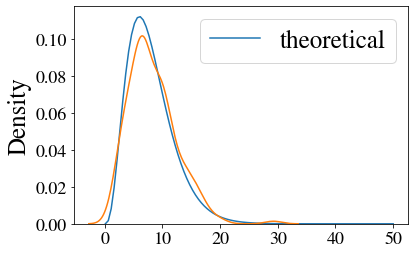

In [288]:
ress = ress_dict[0]
T_vss = np.array([[re["T_v"] for re in res] for res in ress]);
chi_df = Cmat.shape[0]*cur_N

xs = np.linspace(0.1, 50, 100)
theo_curvs_log = chi2.logpdf(xs, chi_df);
plt.plot(xs, np.exp(theo_curvs_log) , label="theoretical")
sns.kdeplot(T_vss[:, 0])
plt.legend()